In [4]:
import tensorly as tl
import tensorly.decomposition as td
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
import seaborn as sns
import dill
import os
from glob import glob
import pandas as pd
import datatable as dt

from functools import partial

In [7]:
bfiles = map(lambda x: f'./data/bangalore-wards-2019-{x}-All-HourlyAggregate.csv', [1,2,3])
bdata = [pd.read_csv(x) for x in bfiles]

In [8]:
MAX_REGION_ID = max([ max(x.sourceid.max(),x.dstid.max()) for x in bdata])
HOURS_IN_DAY = 24
DAYS_IN_WEEK = 5
MONTHS_IN_QUARTER = 3

In [21]:
def maketensor(dframe):
    _T = np.zeros((MAX_REGION_ID,MAX_REGION_ID,HOURS_IN_DAY))
    _T[dframe.dstid-1,dframe.sourceid-1,dframe.hod] = dframe.mean_travel_time
    return _T
    

In [26]:
BENGALURU2019 = list(map(maketensor, bdata))

4957 0.2201331630872844


In [107]:


def fit(RANKS=1):
    ERRORS = []
    FIT_ERRORS0 = []
    FIT_ERRORS2 = []
    
    for __rank in RANKS:
        (weights, factors), errors = td.parafac(BENGALURU2019[1], rank=__rank, return_errors=True, n_iter_max=10000)

        print(len(errors),errors[-1])

        A = np.zeros((np.prod(BENGALURU2019[1].shape), __rank))
        for i in range(__rank):
            temp = np.outer(np.outer(factors[0][:,i], factors[1][:,i]), factors[2][:,i]).reshape(((MAX_REGION_ID,MAX_REGION_ID,HOURS_IN_DAY)))
            A[:,i] = temp.flatten()

            b = np.array([ BENGALURU2019[0].flatten(), BENGALURU2019[2].flatten()])
        b = b.T
        x, residuals, rank, singular_values= np.linalg.lstsq(A,b)
        
        rel_error0 = np.sqrt(residuals[0])/tl.norm(BENGALURU2019[0])
        rel_error2 = np.sqrt(residuals[1])/tl.norm(BENGALURU2019[2])
        
        print(rel_error0, rel_error2)
        
        ERRORS.append(errors[-1])
        FIT_ERRORS0.append(rel_error0)
        FIT_ERRORS2.append(rel_error2)    
    
    return pd.DataFrame({'rank': RANKS , 'errors':ERRORS, 'fit0':FIT_ERRORS0, 'fit1':FIT_ERRORS2})

In [108]:
ranks = [1,2,3,5,7,10,15,20,25,30]
outputdf = fit(ranks)

3 0.41833708381759704
0.43699592430305767 0.4214847097174674


/home/sampad/pyv/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


253 0.3587742820266227
0.38135339935367973 0.35822741850366974
796 0.29366423991094703
0.32212920827289926 0.2927222336224129
6060 0.25202592174763855
0.2810377688492213 0.25418257422288976
3573 0.23570998801655127
0.26414968973781505 0.2393417558603482
4957 0.22013316308732842
0.25009967615196926 0.22564065076875064
6351 0.20546946959638374
0.2390242395226666 0.21338682746108809
8896 0.19649603166116264
0.2303056713293103 0.20628152456407856
10000 0.1898653205160487
0.2266252538719405 0.2021542735148995
10000 0.18510414199327166
0.2254761335915968 0.1992522965036895


<AxesSubplot:xlabel='rank'>

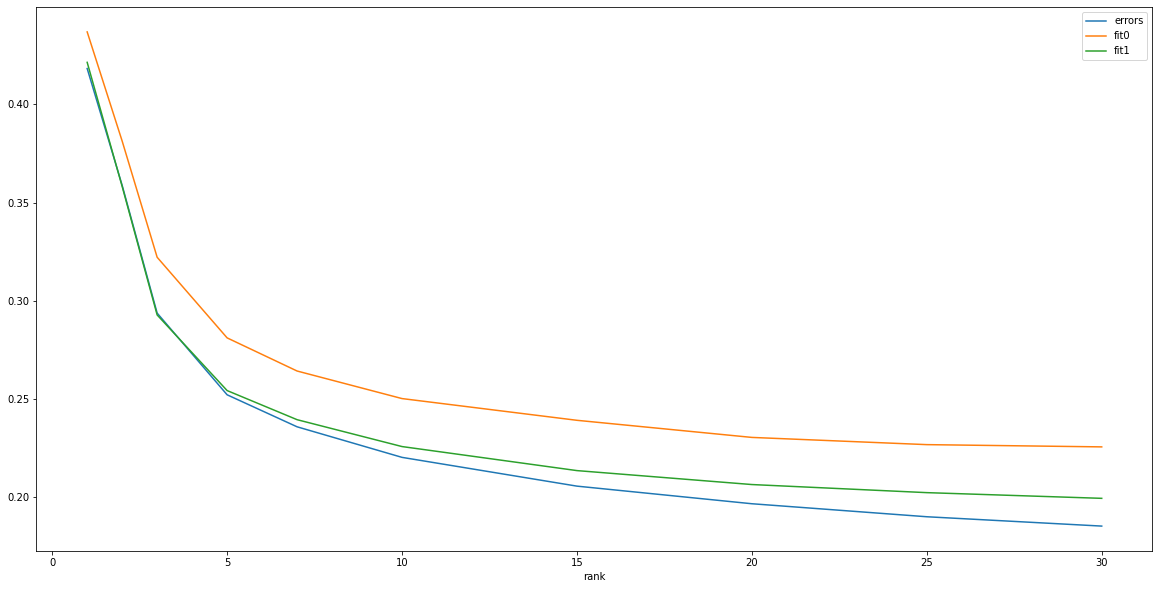

In [115]:
outputdf.plot('rank',['errors','fit0','fit1'])